<a href="https://colab.research.google.com/github/reysilvaa/machine-learning/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRAKTIKUM 1**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'After reading only two of the comments herein, as a lifelong Bronte fan, beginning with Olivier\'s Heathcliff and enduring with the many versions of Charlotte\'s "Rochester," it is more than eye-opening to see that it is the UNsung Bronte sister who gave the lie to the male-chauvinist period the trio inhabited. Of course, the "miracle" in all three versions of 19th-Century British domesticity is that the "girls" were all "spinsters" and their only realistic brushes with "men" were their vicar father and their wastrel? brother. That said, finally, it is ANNE Bronte who has, in her single assay?, proved the "feminist" point, way way ahead of contemporary types, and including the "voting franchise" ranks. However, history evinces more than a few who preceded, including the Greek heterai and Sappho and the likes of an ancient emperor\'s Yang Kuei-fei. And how about "Eve" and her apple?'
 b'"Arahan" adds nothing positive to the Kung Fu genre. To compare this confused motion pictu

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[101, 877,  61, ...,   0,   0,   0],
       [  1,   1, 158, ...,   0,   0,   0],
       [  1,   1,  14, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'After reading only two of the comments herein, as a lifelong Bronte fan, beginning with Olivier\'s Heathcliff and enduring with the many versions of Charlotte\'s "Rochester," it is more than eye-opening to see that it is the UNsung Bronte sister who gave the lie to the male-chauvinist period the trio inhabited. Of course, the "miracle" in all three versions of 19th-Century British domesticity is that the "girls" were all "spinsters" and their only realistic brushes with "men" were their vicar father and their wastrel? brother. That said, finally, it is ANNE Bronte who has, in her single assay?, proved the "feminist" point, way way ahead of contemporary types, and including the "voting franchise" ranks. However, history evinces more than a few who preceded, including the Greek heterai and Sappho and the likes of an ancient emperor\'s Yang Kuei-fei. And how about "Eve" and her apple?'
Round-trip:  after reading only two of the comments [UNK] as a [UNK] [UNK] fan beginning wi

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:

# Contoh teks untuk prediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Ubah teks menjadi array numpy dengan tipe objek (tanpa padding)
sample_array = np.array([sample_text], dtype=object)

# Prediksi menggunakan model
predictions = model.predict(sample_array)
print(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.01583506]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding], dtype=object))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
[-0.01583506]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.5135 - loss: 0.6845 - val_accuracy: 0.7292 - val_loss: 0.5241
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.7815 - loss: 0.4604 - val_accuracy: 0.8182 - val_loss: 0.3604
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.8485 - loss: 0.3503 - val_accuracy: 0.8682 - val_loss: 0.3133
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8587 - loss: 0.3289 - val_accuracy: 0.8453 - val_loss: 0.3374
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8687 - loss: 0.3123 - val_accuracy: 0.8625 - val_loss: 0.3154
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8644 - loss: 0.3136 - val_accuracy: 0.8484 - val_loss: 0.3313
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8705 - loss: 0.3042 - val_accuracy: 0.8708 - val_loss: 0.3084
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.8711 - loss: 0.3022 - 

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8312 - loss: 0.3394
Test Loss: 0.3408503532409668
Test Accuracy: 0.8291599750518799


(0.0, 0.6716417834162712)

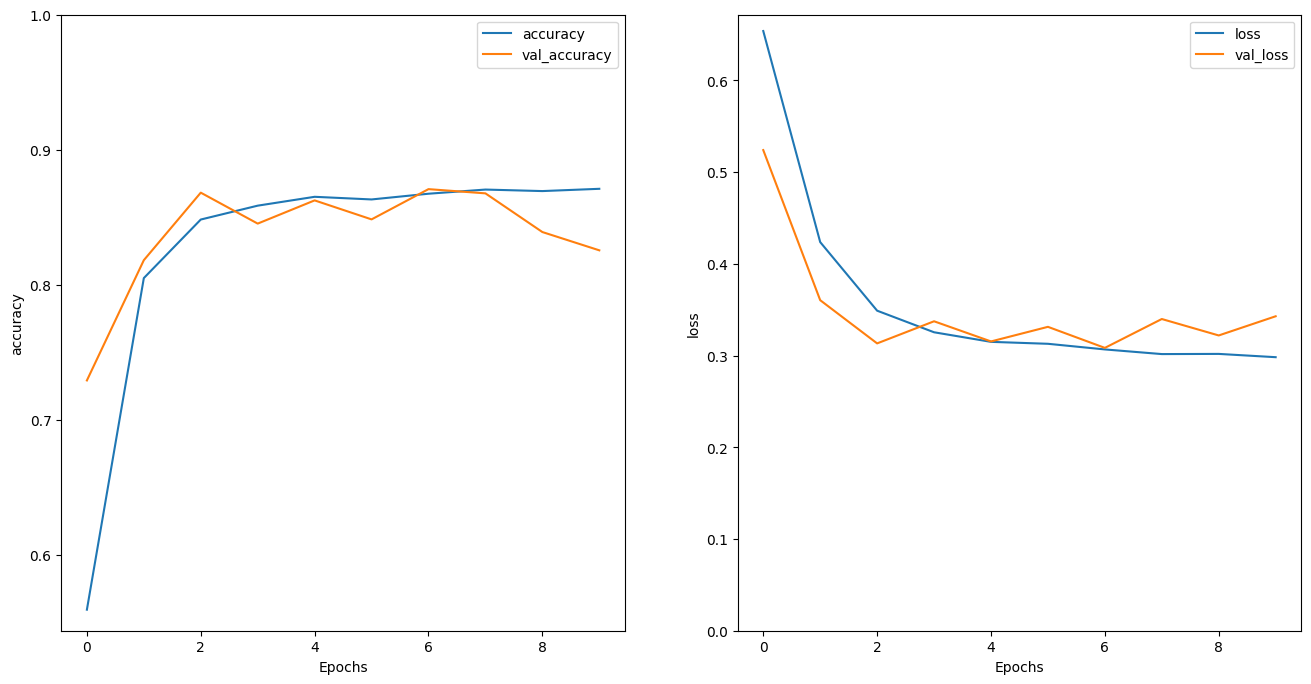

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text],dtype=object))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.8368 - loss: 0.3769 - val_accuracy: 0.8443 - val_loss: 0.3407
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.8602 - loss: 0.3309 - val_accuracy: 0.8635 - val_loss: 0.3211
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - accuracy: 0.8523 - loss: 0.3350 - val_accuracy: 0.8740 - val_loss: 0.2959
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 106ms/step - accuracy: 0.8691 - loss: 0.3099 - val_accuracy: 0.8557 - val_loss: 0.3467
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - accuracy: 0.8667 - loss: 0.3100 - val_accuracy: 0.8604 - val_loss: 0.3355
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 109ms/step - accuracy: 0.8655 - loss: 0.3075 - val_accuracy: 0.8458 - val_loss: 0.3628
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.8730 - loss: 0.3016 - val_accuracy: 0.8656 - val_loss: 0.3111
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.8707 - loss: 0

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8580 - loss: 0.3151
Test Loss: 0.3152426481246948
Test Accuracy: 0.8574399948120117


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
[[-1.7929732]]


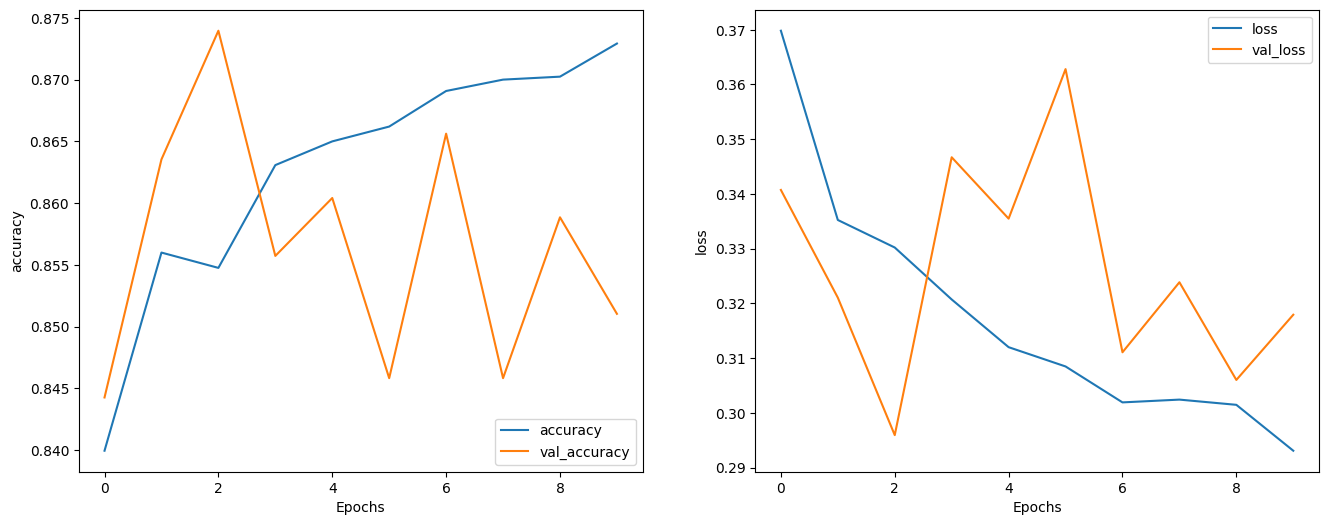

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **PRAKTIKUM 2**

In [54]:
import tensorflow as tf
import numpy as np
import os
import time

In [69]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [64]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [65]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
print(chars)

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>


In [66]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab),mask_token=None)

In [67]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[5, 954, 0, 0, 0, 0, 0], [0, 0, 0]]>

In [ ]:
# Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode
# tf.keras.layers.StringLookup(..., invert=True)

In [75]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

ValueError: Found reserved OOV token at unexpected location in `vocabulary`. Note that passed `vocabulary` does not need to include the OOV and mask tokens. Either remove all mask and OOV tokens, or include them only at the start of the vocabulary in precisely this order: ['[UNK]']. Received: oov_token=[UNK] at vocabulary index [2]

In [73]:
chars = chars_from_ids(ids)
chars

NameError: name 'chars_from_ids' is not defined

In [72]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)


In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)


In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids


In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text


In [ ]:
split_input_target(list("Tensorflow"))

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())


In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()


In [ ]:
sampled_indices

In [ ]:
print("Input:\n",text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n",text_from_ids(sampled_indices).numpy())

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)


In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')